## Imports

In [25]:
import pandas as pd
import numpy as np
import string
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install pyspellchecker
!pip install langdetect
from spellchecker import SpellChecker
from langdetect import detect
import re
from sklearn.metrics import accuracy_score
# !pip install pyenchant
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN,Bidirectional

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading and Preprocessing

In [ ]:
df = pd.read_csv("alldata.csv",header=None)
df.rename(columns={0:'review',1:'label'},inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

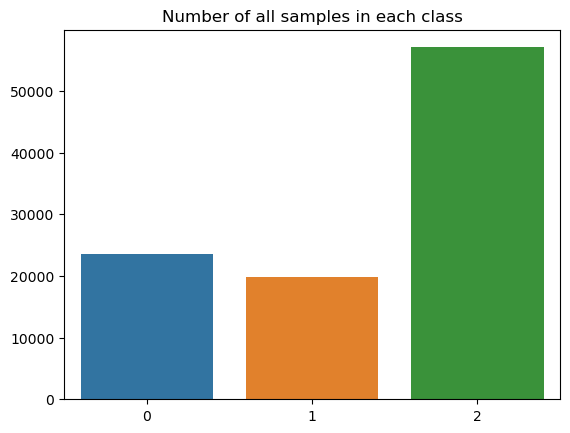

2    57087
0    23485
1    19793
Name: label, dtype: int64


In [ ]:
class_counts = df['label'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Number of all samples in each class')
plt.show()
print(class_counts)

In [ ]:
df = df[df.label!=1]

In [ ]:
df['label'].value_counts()

2    57087
0    23485
Name: label, dtype: int64

In [ ]:
# assume your dataframe is named 'df'
df_label0= df[df['label'] == 0]  
df_label2= df[df['label'] == 2]  

df_label2 = df_label2.iloc[:-30000]
df=pd.concat([df_label0,df_label2])
df.reset_index(drop=True,inplace=True)

In [ ]:
df['label'].value_counts()

2    27087
0    23485
Name: label, dtype: int64

In [ ]:
# Get the indices of the rows where the label is 0
zero_indices = df.index[df.label== 2].tolist()

# Choose the number of rows to drop
num_to_drop = 30000

# Drop random rows where the label is 0
rows_to_drop = np.random.choice(zero_indices, size=num_to_drop, replace=False)
df = df.drop(rows_to_drop)

In [ ]:
df.reset_index(inplace=True,drop=True)

In [ ]:
df

In [ ]:
class TextPreprocessor:
  def __init__(self):
    self.slang_map = {
    "u": "you",
    "luv": "love",
    "ur": "your",
    "r": "are",
    "ya": "you",
    "wanna": "want to",
    "gonna": "going to",
    "wat": "what",
    "wtf": "what the f*ck",
    "omg": "oh my god",
    "btw": "by the way",}
    self.emoji_dict = {"😊": "positive", "😢": "negative", "😠": "negative", "😡": "negative", "😃": "positive",
                  "❤️": "positive", "😍": "positive", "😎": "positive", "😔": "negative", "😒": "negative",
                  "😞": "negative", "😖": "negative", "😘": "positive", "😜": "positive", "😝": "positive",
                  "😤": "negative", "😮": "neutral", "😯": "neutral", "😪": "negative", "😫": "negative",
                  "😴": "neutral", "😌": "neutral", "😛": "positive", "😚": "positive", "😙": "positive",
                  "😗": "positive", "😘": "positive", "😉": "positive", "😊": "positive"}
    

    

  def remove_non_english_words(self,text_list):
    english_text = []
    for text in text_list:
        text = re.sub(r'[^a-zA-Z\s]+', '', text)
               
        english_text.append(text)
    return english_text



  def clean_tokens(self,tokens):
        # remove URLs
        tokens = [re.sub(r'http\S+', '', token) for token in tokens]

        # remove numbers
        tokens = [re.sub(r'\d+', '', token) for token in tokens]

        # remove special characters
        tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

        return tokens
    
  def handle_slang_words(self,text):
        for slang, standard in self.slang_map.items():
            if text == slang:
              text = text.replace(slang, standard)
        return text

  def unique_tokens(self,tokens):
        return list(set(tokens))

  def handle_negations(self,tokens):
        return ["not" + token if token in ['not', 'never', 'no', 'nothing', 'neither', 'nor'] else token for token in tokens]

  def create_ngrams(self,tokens, n):
        if not tokens:
            return []
        return [" ".join(ngram) for ngram in list(nltk.ngrams(tokens, n))]
    
  def remove_special_characters(self,tokens):
      return [re.sub(r'[^\w\s]', '', token) for token in tokens]

  def remove_excessive_whitespaces(self,tokens):
      return [token.strip() for token in tokens if token.strip()]

  def handle_emojis(self,text):
      cleaned_text = []
      for word in text:
          if word in self.emoji_dict:
              sentiment = self.emoji_dict[word]
              cleaned_text.append(sentiment)
          else:
              cleaned_text.append(word)
      return cleaned_text

  
  def preprocessing(self,text):
      #tonkenize
      tokens = nltk.word_tokenize(text)
    
      # Removing non-English words
      tokens=self.remove_non_english_words(tokens)
    
      #stop words
      stop_words = set(nltk.corpus.stopwords.words('english'))
      tokens = [token for token in tokens if token.lower() not in stop_words]
      
      # handling emojis
      tokens = self.handle_emojis(tokens)
        
      # Removing punctuation
      tokens = [token for token in tokens if token not in string.punctuation]
      
      tokens = self.clean_tokens(tokens)
      
      # handle negations
      #tokens=self.handle_negations(tokens)

      #misspelled words
      #tokens=self.correct_misspelled_words(tokens)
      
      #slang words handling
      tokens=self.handle_slang_words(tokens)
        
      # Removing special characters
      tokens= self.remove_special_characters(tokens)

      #lemmatization
      lemmatizer = WordNetLemmatizer()
      tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
      # remove duplicates
      tokens = self.unique_tokens(tokens)

      return tokens


In [ ]:
df_preprocessor = TextPreprocessor()
train_text_list = df['review'].tolist()

In [ ]:
df_processed_texts = []
for text in train_text_list:
    df_processed_texts.append(df_preprocessor.preprocessing(text))

In [ ]:
df['processed_text'] = df_processed_texts
df['processed_text'] = df['processed_text'].apply(' '.join)

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace = True)

In [ ]:
df

,index,review,label,processed_text
0,0,the product is smugging,0,product smugging
1,1,i found it to be clumpy not great,0,clumpy found great
2,2,not the best not the worst makes my under eye ...,0,best remove worst black eye make hard
3,3,its a bit dry,0,bit dry
4,4,two thirds of this app is locked unless you bu...,0,unless color two full third buy app uninstalle...
...,...,...,...,...
50567,50567,very cute customized gift for a bridal shower,2,bridal customized shower cute gift
50568,50568,i love my hanger its perfect thank you so much,2,perfect much thank hanger love
50569,50569,such a hit with the bride and whole bridal par...,2,looked bride bridal great hit dress picture pa...
50570,50570,it was exactly what i had hoped for i love it ...,2,exactly wedding see wait dress hanging hoped love


In [ ]:
df.to_excel('Approach1_English_preprocessed_data.xlsx')

## Loading Preprocessed Data

In [3]:
df=pd.read_excel("Approach1_English_preprocessed_data.xlsx")

In [4]:
df.label.value_counts()

2    27087
0    23485
Name: label, dtype: int64

In [ ]:
x_train,x_test,y_train,y_test =  train_test_split(df['processed_text'],df['label'],random_state=42,test_size=0.2,shuffle=True)

In [ ]:
print("training embedding data: ",x_train.shape[0])
print("testing embedding data: ",x_test.shape[0])

training embedding data:  40457
testing embedding data:  10115


## Tfidf Vectorizer

In [ ]:
word_vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=30000)
unigramdataGet= word_vectorizer.fit_transform(x_train.astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names_out()
x_train=pd.DataFrame(unigramdataGet, columns=vocab)

unigramdataGet= word_vectorizer.transform(x_test.astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names_out()
x_test=pd.DataFrame(unigramdataGet, columns=vocab)

In [ ]:
import pickle
with open('Approach1_English_word_vectorizer_tfidf.pk', 'wb') as f:
    pickle.dump(word_vectorizer, f)

In [ ]:
word_vectorizer = pickle.load(open("Approach1_English_word_vectorizer_tfidf.pk", "rb"))

## Accuracy Function

In [ ]:
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):   
    
    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")

    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")


    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sns.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(x_train)))
    print(classification_report(y_test,  trained_model.predict(x_test)))

## Machine Learning Models

### SVM

In [ ]:
trained_clf_svc = LinearSVC().fit(x_train, y_train)
svc_y_pred=trained_clf_svc.predict(x_test)
test_probabilities = trained_clf_svc._predict_proba_lr(x_test)
train_probabilities = trained_clf_svc._predict_proba_lr(x_train)

# Get the log loss for the test data
test_loss = log_loss(y_test, test_probabilities)
train_loss = log_loss(y_train, train_probabilities)

# Print the training and test accuracies and loss
print("Training accuracy:", trained_clf_svc.score(x_train, y_train)*100)
print("Testing accuracy   :",accuracy_score(svc_y_pred, y_test)*100)
print("Training loss       :", train_loss)
print("Testing loss       :", test_loss)


Training accuracy: 99.09286402847468
Testing accuracy   : 93.83094414236282
Training loss       : 0.27288637502611746
Testing loss       : 0.30527120872949925


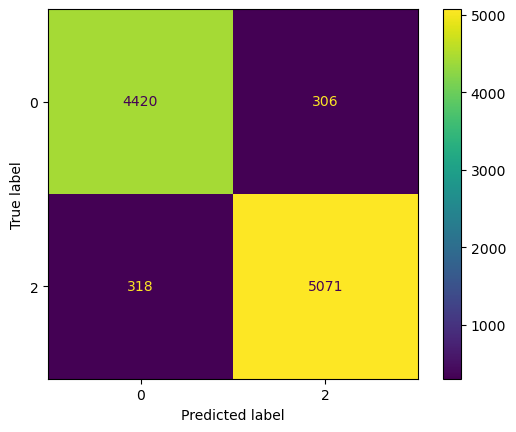

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_svc = confusion_matrix( y_test, svc_y_pred, labels=trained_clf_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=trained_clf_svc.classes_)
disp.plot()
plt.show()

In [ ]:
import pickle
pickle.dump(LinearSVC, open("SVC_English_Model.pk", "wb"))

### Random Forest

Training accuracy  : 99.75035222582001 %
Testing accuracy   : 92.11072664359861 %
precision :  0.9211072664359862
recall    :  0.9211072664359862
f1_score  :  0.9211072664359862


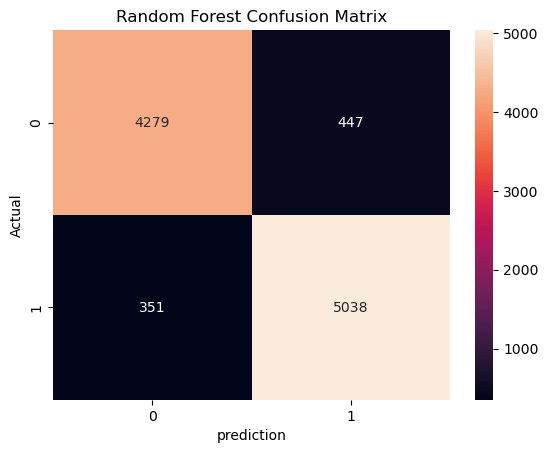

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           2       1.00      1.00      1.00     21698

    accuracy                           1.00     40457
   macro avg       1.00      1.00      1.00     40457
weighted avg       1.00      1.00      1.00     40457

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      4726
           2       0.92      0.93      0.93      5389

    accuracy                           0.92     10115
   macro avg       0.92      0.92      0.92     10115
weighted avg       0.92      0.92      0.92     10115



In [ ]:
from sklearn.ensemble import RandomForestClassifier
trained_clf_random_forest = RandomForestClassifier(n_estimators=50).fit(x_train, y_train)
get_accuracy('Random Forest',trained_clf_random_forest,x_train, y_train, x_test, y_test)

In [ ]:
y_pred = trained_clf_random_forest.predict(x_test)

test_probabilities = trained_clf_random_forest.predict_proba(x_test)
train_probabilities = trained_clf_random_forest.predict_proba(x_train)

# Get the log loss for the test data
test_loss = log_loss(y_test, test_probabilities)
train_loss = log_loss(y_train, train_probabilities)

# Print the training and test accuracies and loss
print("Training accuracy:", trained_clf_random_forest.score(x_train, y_train)*100)
print("Testing accuracy   :",accuracy_score(y_pred, y_test)*100)
print("Training loss       :", train_loss)
print("Testing loss       :", test_loss)

Training accuracy: 99.75035222582001
Testing accuracy   : 92.11072664359861
Training loss       : 0.0695224647996151
Testing loss       : 0.2566162904409422


### Multinomial Naive Bayes

Training accuracy  : 94.594260572954 %
Testing accuracy   : 92.16015818091942 %
precision :  0.9216015818091943
recall    :  0.9216015818091943
f1_score  :  0.9216015818091942


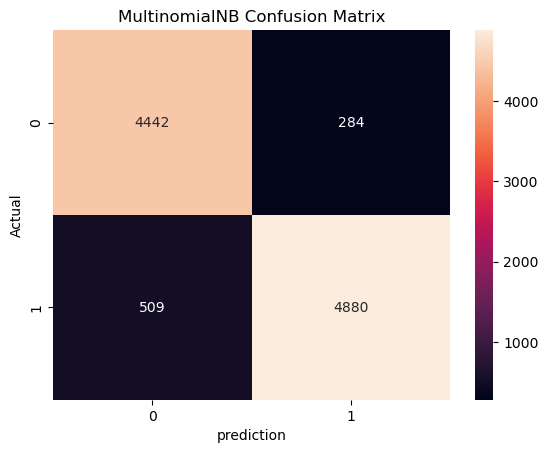

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18759
           2       0.96      0.94      0.95     21698

    accuracy                           0.95     40457
   macro avg       0.95      0.95      0.95     40457
weighted avg       0.95      0.95      0.95     40457

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4726
           2       0.95      0.91      0.92      5389

    accuracy                           0.92     10115
   macro avg       0.92      0.92      0.92     10115
weighted avg       0.92      0.92      0.92     10115



In [ ]:
MNB = MultinomialNB().fit(x_train, y_train)
get_accuracy('MultinomialNB',model,x_train, y_train, x_test, y_test)

In [ ]:
y_pred=MNB.predict(x_test)

test_probabilities = MNB.predict_proba(x_test)
train_probabilities = MNB.predict_proba(x_train)

# Get the log loss for the test data
test_loss = log_loss(y_test, test_probabilities)
train_loss = log_loss(y_train, train_probabilities)

# Print the training and test accuracies and loss
print("Training accuracy:", MNB.score(x_train, y_train)*100)
print("Testing accuracy   :",accuracy_score(y_pred, y_test)*100)
print("Training loss       :", train_loss)
print("Testing loss       :", test_loss)

Training accuracy: 94.594260572954
Testing accuracy   : 92.16015818091942
Training loss       : 0.17357720610501706
Testing loss       : 0.21541917299364924


### LogisticRegression

Training accuracy  : 95.8276688830116 %
Testing accuracy   : 93.71230845279288 %
precision :  0.9371230845279288
recall    :  0.9371230845279288
f1_score  :  0.9371230845279288


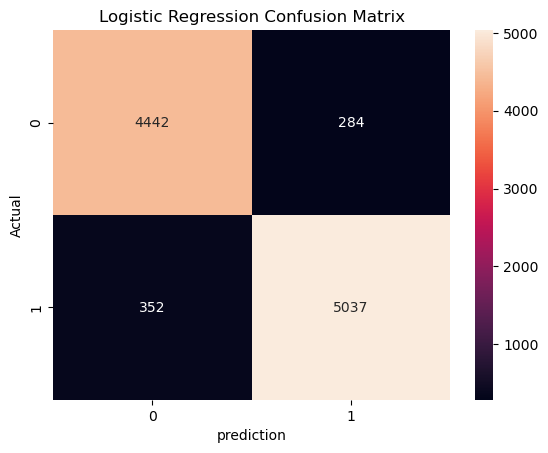

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     18759
           2       0.96      0.96      0.96     21698

    accuracy                           0.96     40457
   macro avg       0.96      0.96      0.96     40457
weighted avg       0.96      0.96      0.96     40457

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4726
           2       0.95      0.93      0.94      5389

    accuracy                           0.94     10115
   macro avg       0.94      0.94      0.94     10115
weighted avg       0.94      0.94      0.94     10115



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# Train the logistic regression model
clf_lg = LogisticRegression(solver='lbfgs').fit(x_train,y_train)
get_accuracy('Logistic Regression',clf_lg,x_train, y_train, x_test, y_test)

In [ ]:
# Predict the labels of the test data
test_predictions = clf_lg.predict(x_test)
print("Training accuracy  :", clf_lg.score(x_train, y_train))
print("Testing accuracy   :",accuracy_score(test_predictions, y_test))
test_probabilities = clf_lg.predict_proba(x_test)
train_probabilities = clf_lg.predict_proba(x_train)

test_loss = log_loss(y_test, test_probabilities)
train_loss = log_loss(y_train, train_probabilities)
print("Training loss      :", train_loss)
print("Testing loss       :", test_loss)

Training accuracy  : 0.958276688830116
Testing accuracy   : 0.9371230845279288
Training loss      : 0.1680034280150038
Testing loss       : 0.19430472021384798


In [ ]:
import pickle
pickle.dump(clf_lg, open("LogisticRegression_English_Model.pk", "wb"))

## Deep Learning Models

### Prepare Data for DL Models

In [16]:
from keras.layers import Input, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, concatenate,Flatten,GlobalMaxPool1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.layers import Bidirectional
from sklearn.metrics import confusion_matrix

In [12]:
import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.87.128.66:8470


REPLICAS:  8


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

min_sample = df.groupby(['label']).count().processed_text.min()
input_data = pd.concat([df[df.label == 0].head(min_sample), 
                        df[df.label == 2].head(min_sample)])

X = input_data.processed_text.astype('str').values #training paramter
Y = np.asarray(input_data.label.values).astype('float32') #prediction paramter
Y = Y.clip(0, 1)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
print("vocab size:",len(tokenizer.word_index))
X = pad_sequences(X, padding='post', maxlen=300)

X_train, X_test, label_train, label_test = train_test_split(X, Y, test_size=0.2, random_state=42,shuffle=True)
print("Training:", len(X_train))
print("Testing: ", len(X_test))

vocab size: 18224
Training: 37566
Testing:  9392


In [46]:
import pickle
pickle.dump(tokenizer, open("Approach1_DL_English_Tokenizer.pk", "wb"))

### RNN

In [28]:
%%time
with strategy.scope():
  dropout = 0.5
  opt = 'adam'
  SimpleRNN = Sequential()
  SimpleRNN.add(keras.layers.Embedding(input_dim=5000, output_dim=100, input_length=300))
  SimpleRNN.add(keras.layers.SimpleRNN(units=100, return_sequences=True))
  SimpleRNN.add(keras.layers.GlobalMaxPool1D())
  SimpleRNN.add(keras.layers.Dense(64, activation='relu'))
  SimpleRNN.add(keras.layers.Dense(32, activation='relu'))
  SimpleRNN.add(keras.layers.Dense(1, activation='sigmoid'))
  SimpleRNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
SimpleRNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 300, 100)          500000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 300, 100)          20100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_9 (Dense)             (None, 64)                6464      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                     

In [29]:
history = SimpleRNN.fit(X_train, label_train, epochs=20, verbose=True,  validation_data=(X_test, label_test),batch_size=64*strategy.num_replicas_in_sync)
loss_val, accuracy_val = SimpleRNN.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/20
74/74 [==============================] - 26s 116ms/step - loss: 0.4351 - accuracy: 0.8145 - val_loss: 0.1872 - val_accuracy: 0.9278
Epoch 2/20
74/74 [==============================] - 4s 54ms/step - loss: 0.1503 - accuracy: 0.9445 - val_loss: 0.1524 - val_accuracy: 0.9412
Epoch 3/20
74/74 [==============================] - 5s 62ms/step - loss: 0.1106 - accuracy: 0.9609 - val_loss: 0.1562 - val_accuracy: 0.9392
Epoch 4/20
74/74 [==============================] - 5s 61ms/step - loss: 0.0920 - accuracy: 0.9679 - val_loss: 0.1590 - val_accuracy: 0.9427
Epoch 5/20
74/74 [==============================] - 6s 78ms/step - loss: 0.0749 - accuracy: 0.9742 - val_loss: 0.1715 - val_accuracy: 0.9395
Epoch 6/20
74/74 [==============================] - 4s 51ms/step - loss: 0.0615 - accuracy: 0.9797 - val_loss: 0.1936 - val_accuracy: 0.9333
Epoch 7/20
74/74 [==============================] - 4s 53ms/step - loss: 0.0462 - accuracy: 0.9856 - val_loss: 0.2084 - val_accuracy: 0.9351
Epoch 8/20


294/294 [==============================] - 5s 13ms/step


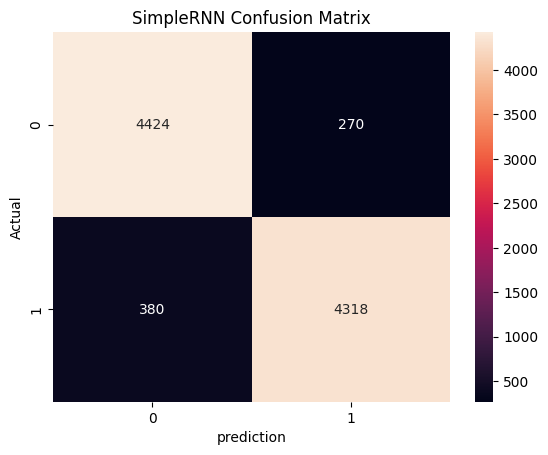

In [30]:
y_pred=SimpleRNN.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_test_class=np.array(label_test)

SimpleRNN = confusion_matrix(y_test_class,y_pred)
sns.heatmap(SimpleRNN,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("SimpleRNN"+ ' Confusion Matrix')
plt.show()

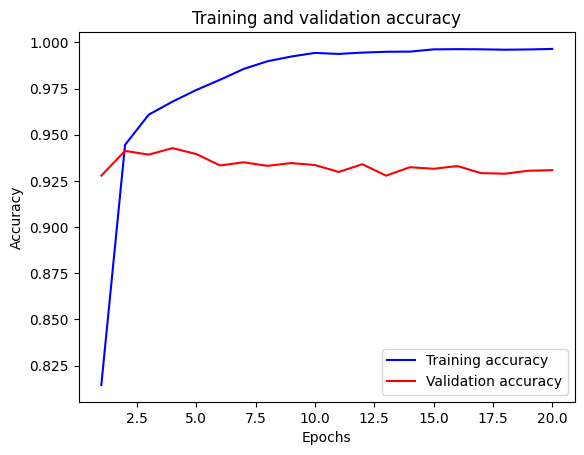

In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy) + 1)

# Plot accuracy  
plt.figure(1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


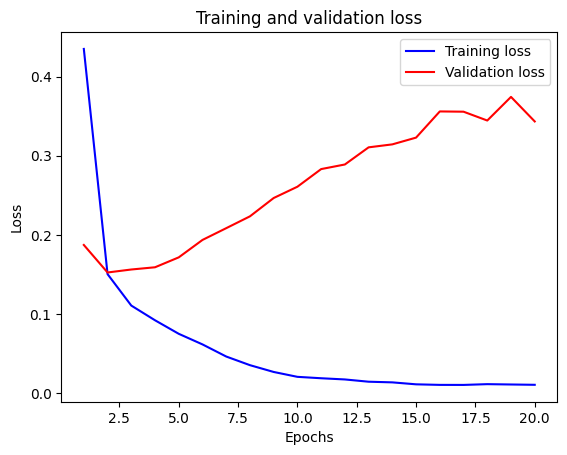

In [32]:
# Plot loss
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### CNN

In [13]:
with strategy.scope():
  embedding_dim = 70
  CNN_LSTM = Sequential()
  CNN_LSTM.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=300))

  CNN_LSTM.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  CNN_LSTM.add((LSTM(100, return_sequences=True)))
  CNN_LSTM.add(Flatten())
  CNN_LSTM.add(Dense(64, activation='relu'))
  CNN_LSTM.add(Dense(32, activation='relu'))
  CNN_LSTM.add(Dense(1, activation='sigmoid'))

  CNN_LSTM.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
CNN_LSTM.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 70)           1275750   
                                                                 
 conv1d_2 (Conv1D)           (None, 298, 32)           6752      
                                                                 
 lstm_2 (LSTM)               (None, 298, 100)          53200     
                                                                 
 flatten_2 (Flatten)         (None, 29800)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1907264   
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                

In [14]:
history6 = CNN_LSTM.fit(X_train, label_train, epochs=20, verbose=True,  validation_data=(X_test, label_test),batch_size=64*strategy.num_replicas_in_sync)
loss_val, accuracy_val = CNN_LSTM.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/20
74/74 [==============================] - 23s 180ms/step - loss: 0.4264 - accuracy: 0.7865 - val_loss: 0.2026 - val_accuracy: 0.9166
Epoch 2/20
74/74 [==============================] - 6s 81ms/step - loss: 0.1510 - accuracy: 0.9429 - val_loss: 0.1485 - val_accuracy: 0.9419
Epoch 3/20
74/74 [==============================] - 6s 81ms/step - loss: 0.1130 - accuracy: 0.9594 - val_loss: 0.1490 - val_accuracy: 0.9421
Epoch 4/20
74/74 [==============================] - 6s 81ms/step - loss: 0.0945 - accuracy: 0.9668 - val_loss: 0.1571 - val_accuracy: 0.9421
Epoch 5/20
74/74 [==============================] - 6s 80ms/step - loss: 0.0823 - accuracy: 0.9719 - val_loss: 0.1748 - val_accuracy: 0.9396
Epoch 6/20
74/74 [==============================] - 6s 81ms/step - loss: 0.0674 - accuracy: 0.9775 - val_loss: 0.1798 - val_accuracy: 0.9355
Epoch 7/20
74/74 [==============================] - 6s 80ms/step - loss: 0.0542 - accuracy: 0.9829 - val_loss: 0.2061 - val_accuracy: 0.9361
Epoch 8/20


294/294 [==============================] - 6s 16ms/step


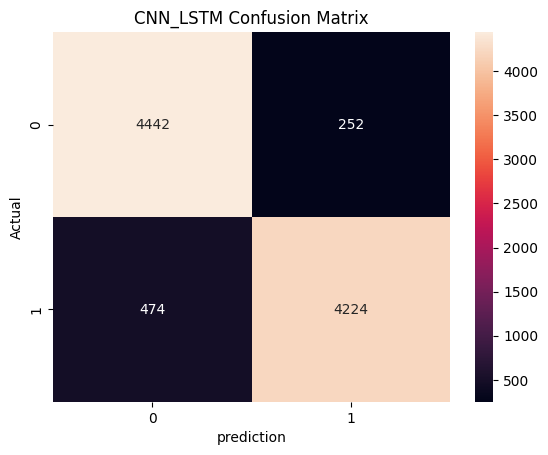

In [18]:
y_pred6=CNN_LSTM.predict(X_test)
y_pred6 = (y_pred6 >= 0.5).astype(int)
y_test_class=np.array(label_test)

cnnlstm = confusion_matrix(y_test_class,y_pred6)
sns.heatmap(cnnlstm,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("CNN_LSTM"+ ' Confusion Matrix')
plt.show()

In [ ]:
CNN_LSTM.save('CNN_LSTM.h5')

### LSTM

In [34]:
# LSTM model with keras
%%time
with strategy.scope():
    dropout = 0.5
    opt = 'adam'
    model2 = Sequential()
    model2.add(Embedding(input_dim=5000, output_dim=100, input_length=300))
    model2.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    model2.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    model2.add(GlobalMaxPool1D())
    model2.add(Dense(32, activation='relu'))
    model2.add(Dropout(dropout))
    model2.add(Dense(1, activation='sigmoid'))

    model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 300, 100)          500000    
                                                                 
 lstm_3 (LSTM)               (None, 300, 100)          80400     
                                                                 
 lstm_4 (LSTM)               (None, 300, 60)           38640     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 32)                1952      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                     

In [35]:
history2 = model2.fit(X_train, label_train, epochs=20, verbose=True,  validation_data=(X_test, label_test),batch_size=64*strategy.num_replicas_in_sync)
loss_val, accuracy_val = model2.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/20
74/74 [==============================] - 57s 354ms/step - loss: 0.5060 - accuracy: 0.7700 - val_loss: 0.4755 - val_accuracy: 0.8108
Epoch 2/20
74/74 [==============================] - 16s 211ms/step - loss: 0.3403 - accuracy: 0.8971 - val_loss: 0.2829 - val_accuracy: 0.9102
Epoch 3/20
74/74 [==============================] - 16s 211ms/step - loss: 0.2460 - accuracy: 0.9248 - val_loss: 0.1950 - val_accuracy: 0.9346
Epoch 4/20
74/74 [==============================] - 16s 219ms/step - loss: 0.2036 - accuracy: 0.9319 - val_loss: 0.1759 - val_accuracy: 0.9298
Epoch 5/20
74/74 [==============================] - 16s 213ms/step - loss: 0.1560 - accuracy: 0.9495 - val_loss: 0.1603 - val_accuracy: 0.9378
Epoch 6/20
74/74 [==============================] - 16s 211ms/step - loss: 0.1428 - accuracy: 0.9561 - val_loss: 0.1681 - val_accuracy: 0.9372
Epoch 7/20
74/74 [==============================] - 16s 211ms/step - loss: 0.1351 - accuracy: 0.9580 - val_loss: 0.1590 - val_accuracy: 0.9387

In [ ]:
model2.save('LSTM_Model.h5')

294/294 [==============================] - 10s 27ms/step


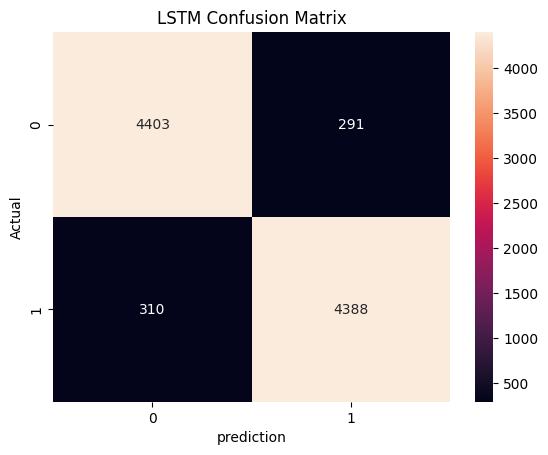

In [36]:
y_pred2=model2.predict(X_test)
y_pred2 = (y_pred2 >= 0.5).astype(int)
y_test_class=np.array(label_test)

lstm = confusion_matrix(y_test_class,y_pred2)
sns.heatmap(lstm,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("LSTM"+ ' Confusion Matrix')
plt.show()

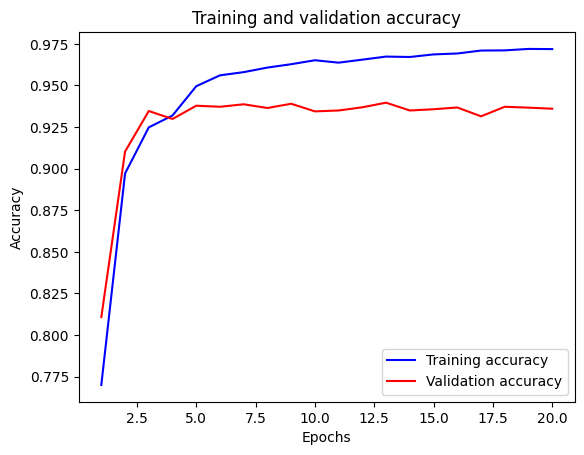

In [37]:
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1,len(accuracy) + 1)

# Plot accuracy  
plt.figure(1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


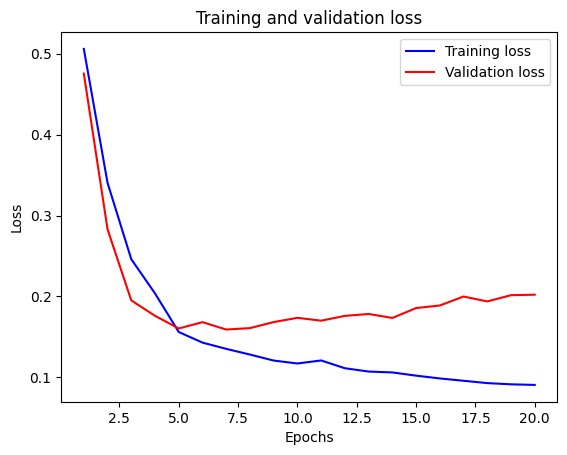

In [38]:
# Plot loss
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### BILSTM

In [39]:
# Define the model architecture
%%time
with strategy.scope():
  embedding_dim = 50
  biLSTM = Sequential()
  biLSTM.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=300))
  biLSTM.add(Bidirectional(LSTM(64)))
  biLSTM.add(Dense(128, activation='relu'))
  biLSTM.add(Dense(64, activation='relu'))
  biLSTM.add(Dropout(0.5))
  biLSTM.add(Dense(32, activation='relu'))
  biLSTM.add(Dense(16, activation='relu'))
  biLSTM.add(Dense(1, activation='sigmoid'))

  from keras import optimizers
  optimizer = optimizers.Adam(learning_rate=0.0001)
  biLSTM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  biLSTM.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 300, 50)           911250    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                     

In [40]:
biLSTM_history = biLSTM.fit(X_train, label_train, epochs=20,batch_size=32*strategy.num_replicas_in_sync,validation_data=(X_test, label_test))

Epoch 1/20
147/147 [==============================] - 40s 163ms/step - loss: 0.6414 - accuracy: 0.6907 - val_loss: 0.4869 - val_accuracy: 0.7858
Epoch 2/20
147/147 [==============================] - 18s 124ms/step - loss: 0.3763 - accuracy: 0.8470 - val_loss: 0.2438 - val_accuracy: 0.8963
Epoch 3/20
147/147 [==============================] - 15s 102ms/step - loss: 0.2078 - accuracy: 0.9221 - val_loss: 0.1814 - val_accuracy: 0.9283
Epoch 4/20
147/147 [==============================] - 15s 102ms/step - loss: 0.1654 - accuracy: 0.9407 - val_loss: 0.1642 - val_accuracy: 0.9361
Epoch 5/20
147/147 [==============================] - 15s 101ms/step - loss: 0.1475 - accuracy: 0.9486 - val_loss: 0.1603 - val_accuracy: 0.9402
Epoch 6/20
147/147 [==============================] - 15s 101ms/step - loss: 0.1326 - accuracy: 0.9543 - val_loss: 0.1567 - val_accuracy: 0.9419
Epoch 7/20
147/147 [==============================] - 15s 101ms/step - loss: 0.1236 - accuracy: 0.9578 - val_loss: 0.1577 - val_ac

In [41]:
loss_val, accuracy_val = biLSTM.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

294/294 [==============================] - 9s 26ms/step - loss: 0.1812 - accuracy: 0.9408
Testing Accuracy:  0.9408


In [45]:
biLSTM.save('Approach1_English_BILSTM_Model.h5')

294/294 [==============================] - 8s 21ms/step


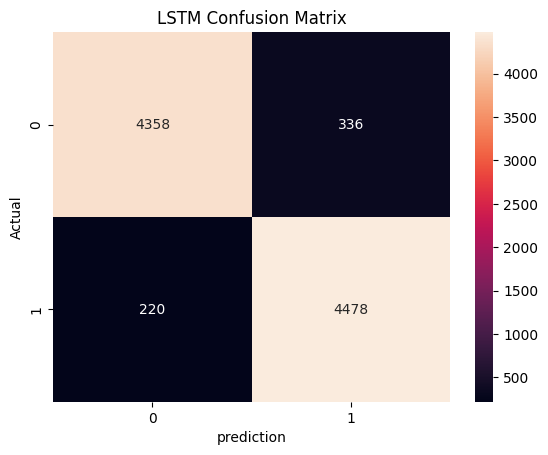

In [42]:
y_pred=biLSTM.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_test_class=np.array(label_test)

lstm = confusion_matrix(y_test_class,y_pred)
sns.heatmap(lstm,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("LSTM"+ ' Confusion Matrix')
plt.show()

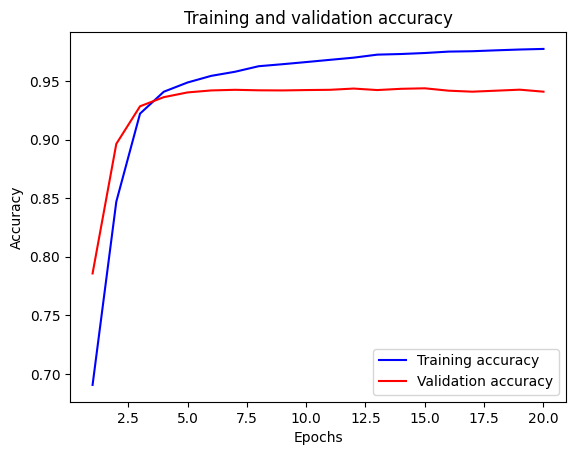

In [43]:
accuracy = biLSTM_history.history['accuracy']
val_accuracy = biLSTM_history.history['val_accuracy']
loss = biLSTM_history.history['loss']
val_loss = biLSTM_history.history['val_loss']

epochs = range(1,len(accuracy) + 1)

# Plot accuracy  
plt.figure(1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

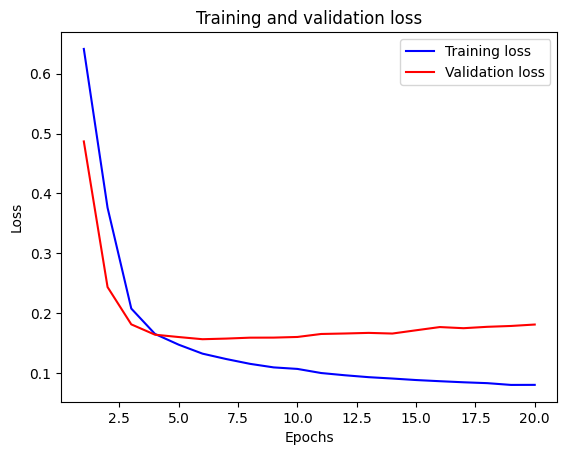

In [44]:
# Plot loss
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Bidirectional GRU

In [51]:
%%time
with strategy.scope():
  #create BIGRU model with keras
  dropout = 0.5
  opt = 'adam'
  # clear_session()
  BIGRU = Sequential()
  BIGRU.add(keras.layers.Embedding(input_dim=5000, output_dim=100, input_length=300))
  # model.add(keras.layers.Bidirectional(keras.layers.GRU(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
  BIGRU.add(Bidirectional(GRU(64)))
  BIGRU.add(Dense(128, activation='relu'))
  BIGRU.add(Dense(64, activation='relu'))
  BIGRU.add(Dropout(0.5))
  BIGRU.add(Dense(32, activation='relu'))
  BIGRU.add(Dense(16, activation='relu'))
  BIGRU.add(Dense(1, activation='sigmoid'))
  BIGRU.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
BIGRU.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 300, 100)          500000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              63744     
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                     

In [52]:
history = BIGRU.fit(X_train, label_train, epochs=20, verbose=True,  validation_data=(X_test, label_test),batch_size=64*strategy.num_replicas_in_sync)
loss_val, accuracy_val = model.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/20
74/74 [==============================] - 38s 330ms/step - loss: 0.3825 - accuracy: 0.8236 - val_loss: 0.1669 - val_accuracy: 0.9343
Epoch 2/20
74/74 [==============================] - 13s 176ms/step - loss: 0.1447 - accuracy: 0.9476 - val_loss: 0.1576 - val_accuracy: 0.9372
Epoch 3/20
74/74 [==============================] - 13s 174ms/step - loss: 0.1188 - accuracy: 0.9585 - val_loss: 0.1513 - val_accuracy: 0.9408
Epoch 4/20
74/74 [==============================] - 13s 174ms/step - loss: 0.1056 - accuracy: 0.9643 - val_loss: 0.1593 - val_accuracy: 0.9409
Epoch 5/20
74/74 [==============================] - 13s 174ms/step - loss: 0.0984 - accuracy: 0.9667 - val_loss: 0.1643 - val_accuracy: 0.9403
Epoch 6/20
74/74 [==============================] - 13s 176ms/step - loss: 0.0896 - accuracy: 0.9698 - val_loss: 0.1695 - val_accuracy: 0.9387
Epoch 7/20
74/74 [==============================] - 13s 175ms/step - loss: 0.0826 - accuracy: 0.9729 - val_loss: 0.1797 - val_accuracy: 0.9397

In [ ]:
BIGRU.save('Approach1_English_BIGRU_Model.h5.h5')

294/294 [==============================] - 15s 44ms/step


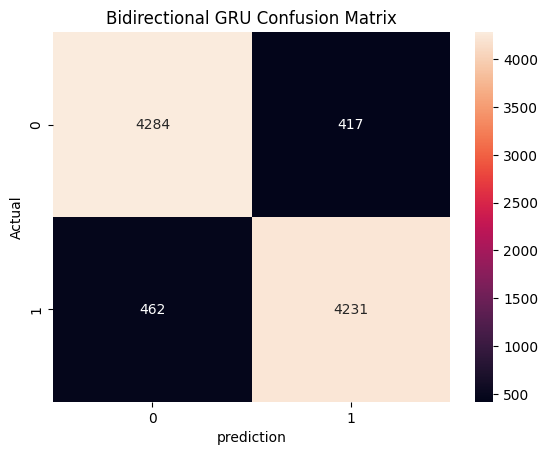

In [ ]:
y_pred=BIGRU.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_test_class=np.array(label_test)

GRU = confusion_matrix(y_test_class,y_pred)
sns.heatmap(GRU,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("Bidirectional GRU"+ ' Confusion Matrix')
plt.show()

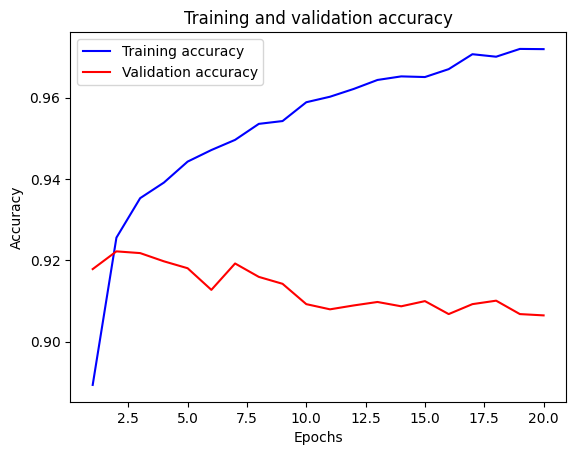

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy) + 1)

# Plot accuracy  
plt.figure(1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

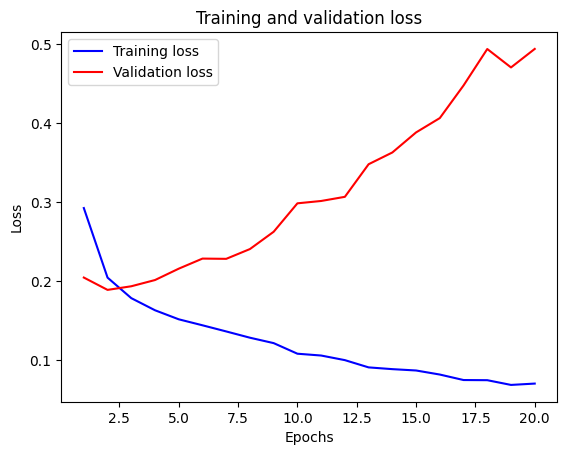

In [ ]:
# Plot loss
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()